In [ ]:
!pip install qiskit

     |████████████████████████████████| 8.3MB 1.9MB/s 
     |████████████████████████████████| 16.5MB 244kB/s 
     |████████████████████████████████| 174kB 39.4MB/s 
     |████████████████████████████████| 174kB 43.7MB/s 
     |████████████████████████████████| 1.9MB 35.8MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 1.1MB 43.6MB/s 
     |████████████████████████████████| 5.8MB 29.5MB/s 
     |████████████████████████████████| 296kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 583kB 40.6MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 2.6MB 44.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.21.0-cp36-none-any.whl size=2875 sha256=39c660d44e39768d60be8b9694dbd40c61592bfcc699af433867c0dfea020abb
  Stored in directory: /root/.cache/pip/wheels/f3/b7/87/cdde69a6f1be1a7d01c751eaae325e306e147d3a2e1a738b44
  Created wheel for



> **TASK 2**


Implement a circuit that returns |01> and |10> with equal probability (50% for each).

Requirements :

1. The circuit should consist only of CNOTs, RXs and RYs. 
2. Start from all parameters in parametric gates being equal to 0 or randomly chosen. 	
3. You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
4. Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

5. Compare the results for different numbers of measurements: 1, 10, 100, 1000


<h1><b>Initial Thoughts and Approach</b></h1>

The Basic Idea Is to Generate:

$\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert10\rangle$

My approach will be to take $\lvert00\rangle$ as input and to 

1. To do a Hadamard-esque(H') procedure to the first qubit with a relative phase(which we will remove for the bonus) :<br>
H'$\lvert0\rangle$--->$\frac{1}{\sqrt{2}}\lvert0\rangle + e^{i\phi}\frac{1}{\sqrt{2}}\lvert1\rangle$
2. Invert the second qubit X$\lvert0\rangle$--->$\lvert1\rangle$

This should give us
$(\frac{1}{\sqrt{2}}\lvert0\rangle + \frac{1}{\sqrt{2}}\lvert1\rangle)\otimes\lvert1\rangle$

Which ends up as:
$\lvert\phi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert11\rangle$

And Finally application of :
CNOT$\lvert\phi\rangle$--->$\lvert\psi\rangle$

As Desired. Let us try to make this circuit and test our hypothesis


In [ ]:
import qiskit as qq
import numpy as np
import matplotlib
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector
from scipy.optimize import minimize
import qiskit.providers.aer.noise as noise
from progressbar import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
qq.__qiskit_version__

{'qiskit': None,
 'qiskit-aer': '0.6.1',
 'qiskit-aqua': '0.7.5',
 'qiskit-ibmq-provider': '0.9.0',
 'qiskit-ignis': '0.4.0',
 'qiskit-terra': '0.15.2'}

In [ ]:
#Table of Variable

#Simulators
simulator = qq.Aer.get_backend('qasm_simulator')
sim2=qq.Aer.get_backend('statevector_simulator')

#Measurements
measurements=[1,10,100,1000]

#Bounds for scipy
b=(0,2*np.pi)
bnds2=(b,b)

#Gradient Descent
learning_rate = 0.1
step_size = 0.003
m_co = 0.35

#Progress Bar
pbar = ProgressBar()


In [ ]:
#Theoretical Circuit
t_circ=qq.QuantumCircuit(2)
t_circ.h(0)
t_circ.x(1)
t_circ.cx(0,1)
t_circ.measure_all()
t_circ.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        ├───┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├─░──╫─┤M├
        └───┘└───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

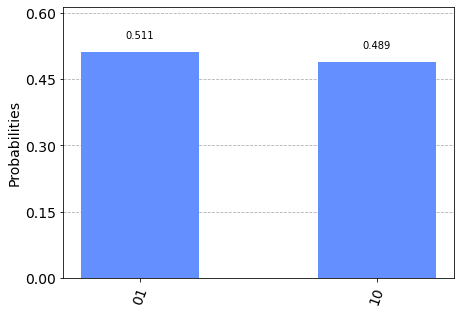

In [ ]:
#Simulate the Result and we get it as expected 
result=qq.execute(t_circ,backend=simulator,noise_model=noise.NoiseModel(), shots=1000).result()
plot_histogram(result.get_counts())

For our approach we will define a certain structure of the circuit replacing the Hadamard and X gate with Rx and Ry gates.

We assume no knowledge of the gates before hand and will try to find the optimal value of the parameterized gates completely through the basic optimization techniques

The good thing is since the state$\lvert\psi\rangle$=
$(\frac{1}{\sqrt{2}}\lvert0\rangle + \frac{1}{\sqrt{2}}\lvert1\rangle)\otimes\lvert1\rangle$

is completely seperable we can treat the problem seperately and deduce the parameter individually for qubit 0(thread 0) and qubit 1(thread 1)

In [ ]:
#Our Guess Circuit Outline where we will determine a,b,c and d
g_circ=qq.QuantumCircuit(2)
g_circ.ry('a',0)
g_circ.rx('b',0)
g_circ.ry('c',1)
g_circ.rx('d',1)
g_circ.cx(0,1)
g_circ.measure_all()
g_circ.draw()

┌───────┐┌───────┐      ░ ┌─┐   
   q_0: ┤ RY(a) ├┤ RX(b) ├──■───░─┤M├───
        ├───────┤├───────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RY(c) ├┤ RX(d) ├┤ X ├─░──╫─┤M├
        └───────┘└───────┘└───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════╩══╩═
                                   0  1

<h1><b>First Optimization method basic scipy SLSQP minimization with varied optimizational parameters</b></h1>

In [ ]:
#Returns list of random guess for parameters
def initial_give(numb):
  Initial = np.random.rand(numb)*2*np.pi
  return Initial
#Objective function for creating circuit with given values and taking measurements and computing cost   
def obj(param):
  cuit=qq.QuantumCircuit(1)
  cuit.ry(param[0],0)
  cuit.rx(param[1],0)
  prob0=0
  prob1=0
  cuit.measure_all()
  result=qq.execute(cuit,backend=simulator,noise_model=noise.NoiseModel(), shots=measurements[j]).result()
  k=result.get_counts()
  if '1' in k.keys():
    prob1=k.get("1")/measurements[j]
  if '0' in k.keys():
    prob0=k.get("0")/measurements[j]
  return cost_1(thread,prob0,prob1)

#cost function
def cost_1(thread,prob0,prob1):
  if thread==0:
    return float((prob0-0.5)**2+(prob1-0.5)**2)
  elif thread==1:
    return float(prob0-0)**2+(prob1-1)**2



In [ ]:
#Optimize values for the first thread and save different parameters for each measurement count
ygate0=[]
xgate0=[]
thread=0
for j in range(4):
  #j determines the measurment ammount
  print("\nResult with number of measurement shots: ", measurements[j])
  for i in range(500):
    #i causes us to loop over and find multiple minimas and find the best one while randomly initiating the optimization function to avoid local minimas
    if i==0:
      prev=minimize(obj,initial_give(2), method='SLSQP',bounds=bnds2)
      final=prev
      continue
    sol=minimize(obj,initial_give(2), method='SLSQP',bounds=bnds2)
    if sol.fun<=final.fun:
      final=sol
  print("\nFinal Value of obj:",final.fun)
  print("\nFinal Value of parameter:",final.x)
  ygate0.append(final.x[0])
  xgate0.append(final.x[1])



Result with number of measurement shots:  1

Final Value of obj: 0.5

Final Value of parameter: [1.8876791  3.16183448]

Result with number of measurement shots:  10

Final Value of obj: 0.0

Final Value of parameter: [1.84655731 4.99725375]

Result with number of measurement shots:  100

Final Value of obj: 0.0

Final Value of parameter: [2.00479315 1.38301596]

Result with number of measurement shots:  1000

Final Value of obj: 2.0000000000000037e-06

Final Value of parameter: [0.06836432 1.56961227]


In [ ]:
#Get Optimized values for second thread and get values for each measurement 
ygate1=[]
xgate1=[]
thread=1
for j in range(4):
  #j determines the different measurement values
  print("\nResult with number of measurement shots: ", measurements[j])
  for i in range(500):
    #i causes us to loop over and find multiple minimas and find the best one while randomly initiating the optimization function to avoid local minimas
    if i==0:
      prev=minimize(obj,initial_give(2), method='SLSQP',bounds=bnds2)
      final=prev
      continue
    sol=minimize(obj,initial_give(2), method='SLSQP',bounds=bnds2)
    if sol.fun<=final.fun:
      final=sol
  print("\nFinal Value of obj:",final.fun)
  print("\nFinal Value of parameter:",final.x)
  ygate1.append(final.x[0])
  xgate1.append(final.x[1])


Result with number of measurement shots:  1

Final Value of obj: 0.0

Final Value of parameter: [3.81408642 1.83083188]

Result with number of measurement shots:  10

Final Value of obj: 0.0

Final Value of parameter: [0.19510179 2.69784602]

Result with number of measurement shots:  100

Final Value of obj: 0.0

Final Value of parameter: [0.09530344 3.28028684]

Result with number of measurement shots:  1000

Final Value of obj: 0.0

Final Value of parameter: [0.0204894  3.16571219]


In [ ]:
result_plot=[]
for j in range(4):
  fr=qq.QuantumCircuit(2)
  fr.ry(ygate0[j],0)
  fr.rx(xgate0[j],0)
  fr.ry(ygate1[j],1)
  fr.rx(xgate1[j],1)
  fr.cx(0,1)
  fr.measure_all()
  result=qq.execute(fr,backend=simulator,noise_model=noise.NoiseModel(), shots=measurements[j]).result()
  result_plot.append(result.get_counts())
fr.draw()

┌──────────────┐┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(0.068364) ├┤ RX(1.5696) ├──■───░─┤M├───
        ├──────────────┤├────────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RY(0.020489) ├┤ RX(3.1657) ├┤ X ├─░──╫─┤M├
        └──────────────┘└────────────┘└───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════╩══╩═
                                               0  1

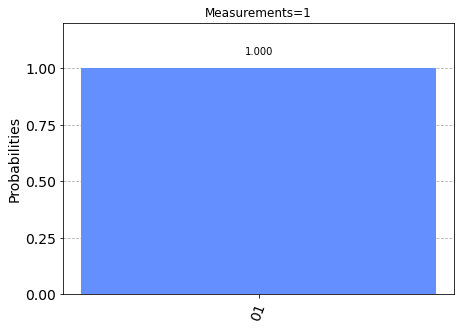

In [ ]:
plot_histogram(result_plot[0],title="Measurements=1")

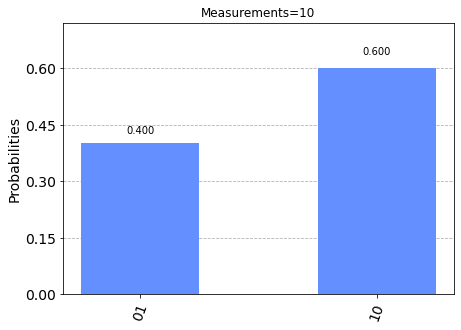

In [ ]:
plot_histogram(result_plot[1],title="Measurements=10")

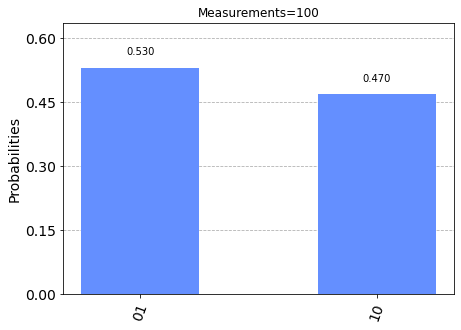

In [ ]:
plot_histogram(result_plot[2],title="Measurements=100")

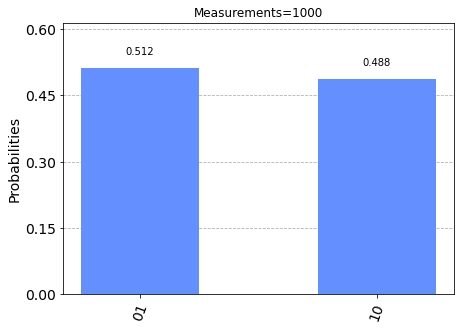

In [ ]:
plot_histogram(result_plot[3],title="Measurements=1000")

<h1><b> Results for Optimization Method 1 and Some Analysis</b></h1>
We notice that we got reasonably good results which improved as we increase the number of measurement shots.
This is obvious since for very small number of shots the result would be either 0 or 1 which does not give the optimization algorithm a good idea of how the quantum probablities of the state vector are distributed since the objective function itself remains constant

With more shots the picture becomes clearer allowing us to reduce the cost function sufficiently to get a good result


<h1><b>Optimization Method 2 Gradient Descent</b></h1>
I believe it would be interesting to see how Gradient Descent would tackle the same problem and If there would be any differences

In [ ]:
# some functions
def cal_grad(func,params,o_val):
  gd=[]
  new=params.copy()
  #calulate gradient for each degree of freedom(in this case 2) while keeping other constant
  for i in range(2):
    new[i]=params[i]+step_size
    n_val=func(new)
    gd.append((n_val-o_val)/step_size)
  return gd

def update(n_grad,o_grad,params):
  upparams=[]
  if True:
    for i in range(2):
      params[i]-= learning_rate*(n_grad[i]*m_co + (1-m_co)*o_grad[i])
      params[i] =  params[i] % (2*np.pi)#restrict to our range
      upparams.append(params[i])

  return upparams

def grad_des(func,params):
  cost=[]
  ite=[]
  o_params=params.copy()
  o_val=func(params)
  for iter in range(1000):
    ite.append(iter)
    cost.append(o_val)
    #caluclate the gradient
    n_grad=cal_grad(func,params,o_val)
    if (iter==0):
      o_grad=n_grad
    #Update the parameters
    params=update(n_grad,o_grad,params)
    o_grad=n_grad
    n_val=func(params)
    #Compare with old value of cost/objective and save the minimum
    if n_val<o_val:
      o_val=n_val
      o_params=params.copy()
  return cost,o_val,o_params
  

In [ ]:
loss0=[]
loss1=[]
para0=[]
para1=[]
for j in range(4):
  print("For Measurements: ",measurements[j])
  thread=0
  cost0,objvalue0,params0=grad_des(obj,initial_give(2))
  loss0.append(cost0)
  para0.append(params0)
  print("For Thread: ",thread)
  print("Final cost value: ",objvalue0)
  print("Final Parameters: ",params0)
  thread=1
  cost1,objvalue1,params1=grad_des(obj,initial_give(2))
  loss1.append(cost1)
  para1.append(params1)
  print("For Thread: ",thread)
  print("Final cost value: ",objvalue1)
  print("Final Parameters: ",params1)



For Measurements:  1
For Thread:  0
Final cost value:  0.5
Final Parameters:  [6.19076132 4.51138075]
For Thread:  1
Final cost value:  0.0
Final Parameters:  [2.30381212 0.46674054]
For Measurements:  10
For Thread:  0
Final cost value:  0.0
Final Parameters:  [3.766760015570876, 0.7575550938996578]
For Thread:  1
Final cost value:  0.0
Final Parameters:  [2.62739259509933, 5.995695863182604]
For Measurements:  100
For Thread:  0
Final cost value:  0.0
Final Parameters:  [4.759866028775285, 3.8696851141631825]
For Thread:  1
Final cost value:  0.0
Final Parameters:  [0.03939278432821108, 3.216574053914663]
For Measurements:  1000
For Thread:  0
Final cost value:  0.0
Final Parameters:  [4.90603662356709, 1.5894117196392656]
For Thread:  1
Final cost value:  2.000000000000002e-06
Final Parameters:  [3.0994713688909528, 6.251140951488914]


In [ ]:
result_plot=[]
for j in range(4):
  fr=qq.QuantumCircuit(2)
  fr.ry(para0[j][0],0)
  fr.rx(para0[j][1],0)
  fr.ry(para1[j][0],1)
  fr.rx(para1[j][1],1)
  fr.cx(0,1)
  fr.measure_all()
  result=qq.execute(fr,backend=simulator,noise_model=noise.NoiseModel(), shots=measurements[j]).result()
  result_plot.append(result.get_counts())
fr.draw()

┌───────────┐ ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(4.906) ├─┤ RX(1.5894) ├──■───░─┤M├───
        ├───────────┴┐├────────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RY(3.0995) ├┤ RX(6.2511) ├┤ X ├─░──╫─┤M├
        └────────────┘└────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1

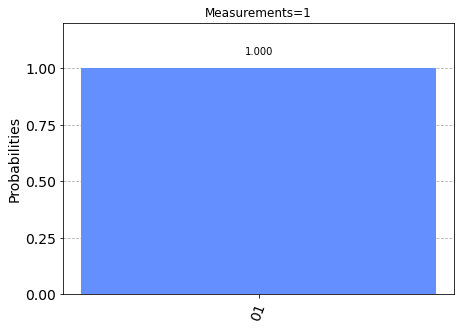

In [ ]:
plot_histogram(result_plot[0],title="Measurements=1")

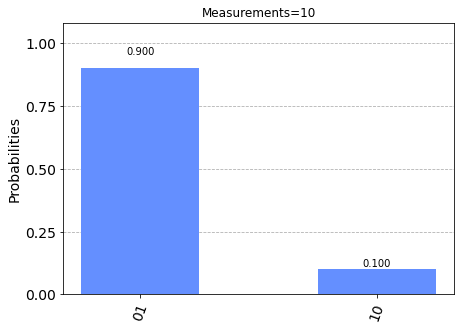

In [ ]:
plot_histogram(result_plot[1],title="Measurements=10")

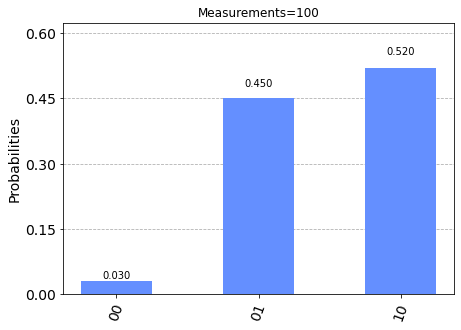

In [ ]:
plot_histogram(result_plot[2],title="Measurements=100")

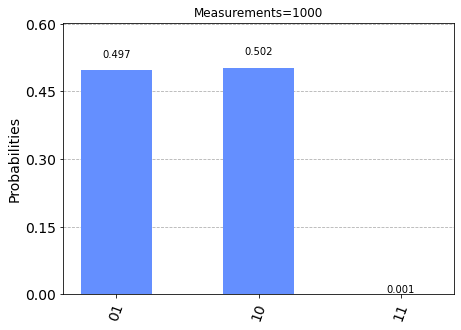

In [ ]:
plot_histogram(result_plot[3],title="Measurements=1000")

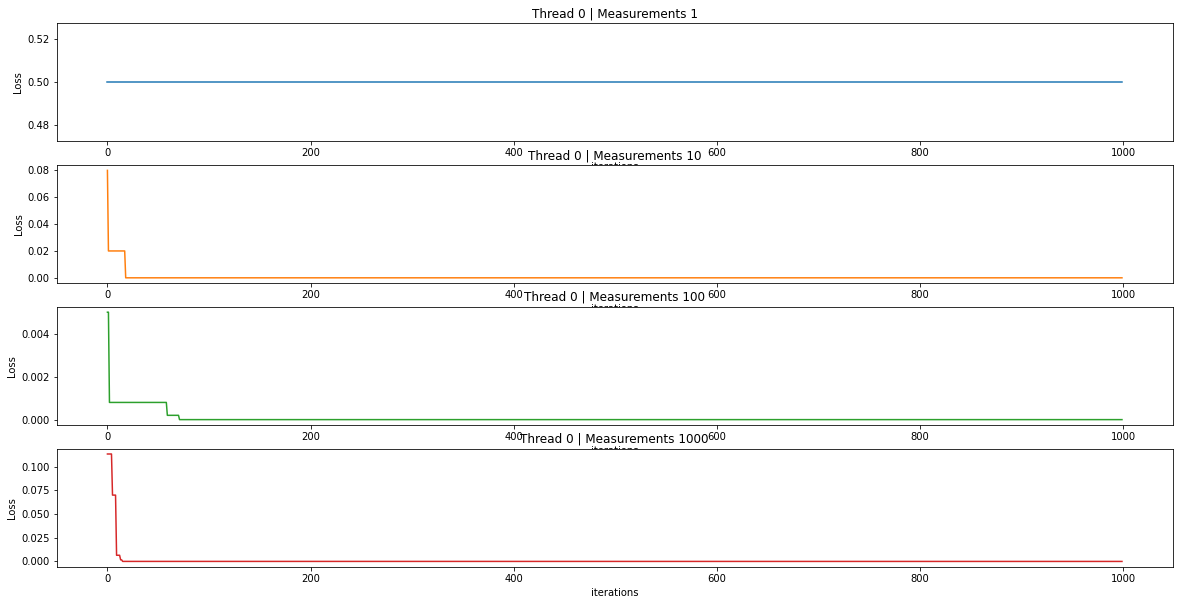

In [ ]:
fig, axs = plt.subplots(4)
fig.set_size_inches(20, 10)
axs[0].plot(loss0[0])
axs[0].set_title('Thread 0 | Measurements 1')
axs[1].plot(loss0[1], 'tab:orange')
axs[1].set_title('Thread 0 | Measurements 10')
axs[2].plot(loss0[2], 'tab:green')
axs[2].set_title('Thread 0 | Measurements 100')
axs[3].plot(loss0[3], 'tab:red')
axs[3].set_title('Thread 0 | Measurements 1000')
for ax in axs.flat:
    ax.set(xlabel='iterations', ylabel='Loss')

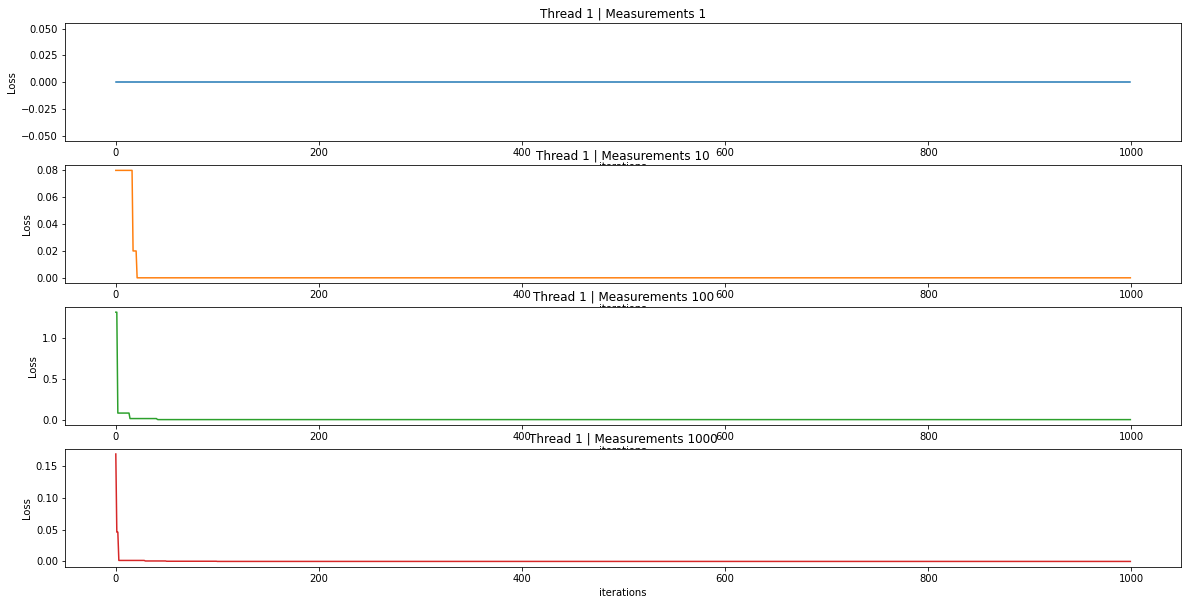

In [ ]:
fig, axs = plt.subplots(4)
fig.set_size_inches(20, 10)
axs[0].plot(loss1[0])
axs[0].set_title('Thread 1 | Measurements 1')
axs[1].plot(loss1[1], 'tab:orange')
axs[1].set_title('Thread 1 | Measurements 10')
axs[2].plot(loss1[2], 'tab:green')
axs[2].set_title('Thread 1 | Measurements 100')
axs[3].plot(loss1[3], 'tab:red')
axs[3].set_title('Thread 1 | Measurements 1000')
for ax in axs.flat:
    ax.set(xlabel='iterations', ylabel='Loss')

<h1><b> Results And Analysis of Optimization Method 2</b></h1>
The results are pretty similar to that with SLSQP optimization 

For the case of measurements=1 we see that we get a straight line. This is obvious since we are either supposed to get a 1 or a 0. Meaning the cost function stays the same and does not vary at all staying constant at 0

We see that our results greatly improve as Measurement increase. This is because the measured probablities start to better reflect the quantum state of the qubit and so the gradient descent algorithm works better on the defined cost function. 

<h1><b>Comparison between SLSQP and Gradient Descent</b></h1>
The results from the two are pretty similar however the ways they achieve these results is disparate

For Method 1 we use SlSQP with given bounds and an initial guess for the parameters. The in-built method returns us a parameter corresponding the lowest value of the objective function but since we don't know if this is a local minima we have to re-initialize the guess parameters and run the loop several times to ensure we have gotten a global minima. 
While this does achieve fair results, as we see from the histogram, the methodology itself takes advantage of the fact that we have a small domain with few local minimas which we can traverse and compare in 500 cycles, This would not work for large ranges or with functions with many local minima

Method 2 is a generic gradient descent algorithm with its constants, learning rate, step size etc, set after experimentation. The gradient is taken through numerical methodolgy where we use the formal defination of the gradient 

  $\frac{\partial f}{\partial x}=	\lim_{h \to 0}\frac{f(x+h,y)-f(x,y)}{h}$   
to calculate the derivative with respect to each degree of freedom which is then put into the generic update formula for parameters.

<h1><b1>Bonus Question</b></h1>
The basic ideas is that the Optimization performed in the previous part does not account for the relative phase
meanning there are an infinite number of state vectors which correspond to $\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}e^{i\phi}\lvert10\rangle$

where $\phi$ can be any relative phase

We have to restrict this relative phase to $\phi$=0

For our approach we realise that this operation simple requires us to model a true Hadamard gate and go from $\lvert0\rangle$ to the X basis vector $\lvert+\rangle$

H$\lvert0\rangle=\lvert+\rangle$

We will modify the cost function to account for the phase and only change the values of Thread 0 since Thread 1 only adds a global phase which can be ignored

As Always we first start with a guess and see whether the Hadamard gate truly gives us the require phase

In [ ]:
check=qq.QuantumCircuit(1)
check.h(0)
check.draw()

┌───┐
q_0: ┤ H ├
     └───┘

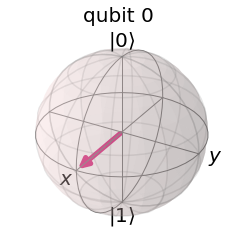

In [ ]:
sim2=qq.Aer.get_backend('statevector_simulator')
results=qq.execute(check,backend=sim2,noise_model=noise.NoiseModel()).result()
a=results.get_statevector()
plot_bloch_multivector(a)

Since we see our Idea is correct, now It is time to use the same optimization techniques to deduce values for Ry and Rx to get a true Hadamard quantum gate

We also reiterate that the second thread/qubit does not need to be changed since the gate operation on it will only introduce a global phase, therefore optimization of only the first gate is more than sufficient

In [ ]:
#New Objective Function with updated Costs
def obj_bonus(param):
  cuit=qq.QuantumCircuit(1)
  cuit.ry(param[0],0)
  cuit.rx(param[1],0)
  results=qq.execute(cuit,backend=sim2,noise_model=noise.NoiseModel()).result()
  state_vector=results.get_statevector()
  r1=state_vector[0].real
  i1=state_vector[0].imag
  r2=state_vector[1].real
  i2=state_vector[1].imag
  c=1/np.sqrt(2)
  return (r1-c)**2+(r2-c)**2+(i1)**2+(i2)**2


<h1><b>Using Scipy Optimization techniques</b></h1>

In [ ]:
final=minimize(obj_bonus,initial_give(2), method='SLSQP',bounds=bnds2)

In [ ]:
cuit=qq.QuantumCircuit(1)
cuit.ry(final.x[0],0)
cuit.rx(final.x[1],0)
results=qq.execute(cuit,backend=sim2,noise_model=noise.NoiseModel()).result()
state_vector=results.get_statevector()
print(state_vector)

[0.70743098+0.j         0.70678238-0.00027505j]


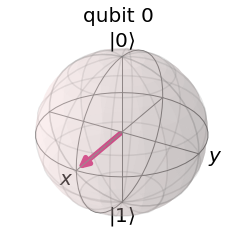

In [ ]:
plot_bloch_multivector(state_vector)

<h1><b>Using Gradient Descent</b></h1>

In [ ]:
costs,objva,par=grad_des(obj_bonus,initial_give(2))

In [ ]:
cuit=qq.QuantumCircuit(1)
cuit.ry(par[0],0)
cuit.rx(par[1],0)
results=qq.execute(cuit,backend=sim2,noise_model=noise.NoiseModel()).result()
state_vector=results.get_statevector()
print(state_vector)

[0.70695961+0.j         0.70724619-0.00330635j]


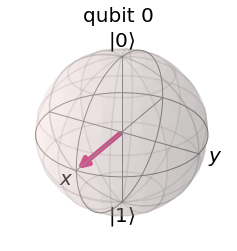

In [ ]:
plot_bloch_multivector(state_vector)

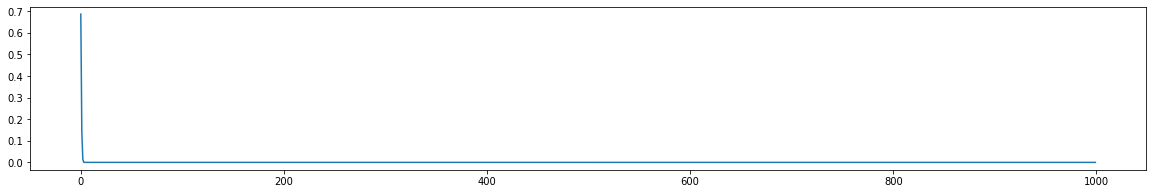

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(costs)